# 🤖 Entraînement Autoencoder – Détection d'Anomalies Audio (DCASE 2024 Task 2)

Ce notebook a pour objectif de :

- Charger les vecteurs de features audio prétraités
- Entraîner un autoencodeur non supervisé sur les sons **normaux**
- Identifier les anomalies par reconstruction dégradée
- Évaluer la performance par l’erreur de reconstruction + AUC

---

📦 **Prérequis** :
- Features extraites et sauvegardées dans `FEATURES_DIR`
- Normalisation préalable effectuée


In [1]:
# 📌 Librairies standards
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# 🤖 Deep Learning
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# 📌 Configuration globale
import warnings
warnings.filterwarnings('ignore')

# 📂 Ajout dynamique du répertoire principal au PYTHONPATH
project_root = Path.cwd().parent  # DCASE2024_ASD_Project/
sys.path.append(str(project_root))

# 🔧 Ajout de la racine du projet dans le PYTHONPATH
#project_root = Path(__file__).resolve().parent.parent  # ou adapte manuellement
#sys.path.append(str(project_root))

# 🔧 Projet
from src import config, processing
from src.utils.logger_utils import logger


In [1]:
# 📊 Options d'affichage
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("pastel")
%matplotlib inline

# 📂 Chargement des features audio
X, y = processing.load_audio_features(config.FEATURES_DIR)

# ✅ Vérification des dimensions
logger.info(f"X shape = {X.shape}, y shape = {y.shape}")


2025-03-22 21:29:12 - INFO - Loading normalized features from C:\Users\guidy\Documents\Datascience\Data\sound_datasets\DCASE_DATASET\features...
🔄 Processing machine types: 0it [00:00, ?it/s]
📂 fan - loading split files: 0it [00:00, ?it/s]
📂 fan - loading split files: 1it [00:01,  1.61s/it]
📂 fan - loading split files: 2it [00:03,  1.82s/it]
🔄 Processing machine types: 1it [00:03,  3.58s/it] 
📂 pump - loading split files: 0it [00:00, ?it/s]
📂 pump - loading split files: 1it [00:00,  2.40it/s]
📂 pump - loading split files: 2it [00:02,  1.17s/it]
🔄 Processing machine types: 2it [00:05,  2.73s/it]  
📂 slider - loading split files: 0it [00:00, ?it/s]
📂 slider - loading split files: 1it [00:00,  1.65it/s]
📂 slider - loading split files: 2it [00:01,  1.03s/it]
🔄 Processing machine types: 3it [00:07,  2.37s/it]    
📂 ToyCar - loading split files: 0it [00:00, ?it/s]
📂 ToyCar - loading split files: 1it [00:01,  1.36s/it]
📂 ToyCar - loading split files: 2it [00:03,  1.69s/it]
🔄 Processing machin

In [2]:
# 🎯 Moyenne temporelle → vecteur par fichier
X_mean = X.mean(axis=2)

# ⚠️ Entraînement uniquement sur les sons normaux
X_normal = X_mean[y == 0]

# 📦 Split train / validation
X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)

# ⚖️ Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


## 🧱 Bloc 1 – Architecture de l’Autoencoder

Le modèle utilisé est un autoencodeur dense symétrique :
- Une couche d'encodage (relu)
- Une couche de décodage (linéaire)


In [3]:
# 🔧 Architecture de base
input_dim = X_train_scaled.shape[1]
encoding_dim = 64

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="linear")(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(1e-3), loss="mse")

autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 147)]             0         
                                                                 
 dense (Dense)               (None, 64)                9472      
                                                                 
 dense_1 (Dense)             (None, 147)               9555      
                                                                 
Total params: 19,027
Trainable params: 19,027
Non-trainable params: 0
_________________________________________________________________


## 🚀 Bloc 2 – Entraînement de l'Autoencoder

Entraînement sur les sons normaux (80%) avec validation sur 20%.
La fonction de perte est l’erreur quadratique moyenne (MSE).


In [4]:
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    validation_data=(X_val_scaled, X_val_scaled),
    epochs=100,
    batch_size=256,
    verbose=1
)


Epoch 1/100
80/80 [==============================] - 1s 6ms/step - loss: 0.9584 - val_loss: 0.7516
Epoch 2/100
80/80 [==============================] - 0s 4ms/step - loss: 0.6785 - val_loss: 0.6200
Epoch 3/100
80/80 [==============================] - 0s 4ms/step - loss: 0.5841 - val_loss: 0.5551
Epoch 4/100
80/80 [==============================] - 0s 3ms/step - loss: 0.5328 - val_loss: 0.5171
Epoch 5/100
80/80 [==============================] - 0s 4ms/step - loss: 0.5015 - val_loss: 0.4931
Epoch 6/100
80/80 [==============================] - 0s 4ms/step - loss: 0.4810 - val_loss: 0.4767
Epoch 7/100
80/80 [==============================] - 0s 4ms/step - loss: 0.4654 - val_loss: 0.4631
Epoch 8/100
80/80 [==============================] - 0s 4ms/step - loss: 0.4516 - val_loss: 0.4503
Epoch 9/100
80/80 [==============================] - 0s 3ms/step - loss: 0.4383 - val_loss: 0.4377
Epoch 10/100
80/80 [==============================] - 0s 4ms/step - loss: 0.4253 - val_loss: 0.4254
Epoch 11/

80/80 [==============================] - 0s 4ms/step - loss: 0.3434 - val_loss: 0.3591
Epoch 84/100
80/80 [==============================] - 0s 4ms/step - loss: 0.3435 - val_loss: 0.3587
Epoch 85/100
80/80 [==============================] - 0s 5ms/step - loss: 0.3435 - val_loss: 0.3586
Epoch 86/100
80/80 [==============================] - 0s 4ms/step - loss: 0.3433 - val_loss: 0.3591
Epoch 87/100
80/80 [==============================] - 0s 4ms/step - loss: 0.3434 - val_loss: 0.3594
Epoch 88/100
80/80 [==============================] - 0s 5ms/step - loss: 0.3432 - val_loss: 0.3588
Epoch 89/100
80/80 [==============================] - 0s 4ms/step - loss: 0.3432 - val_loss: 0.3589
Epoch 90/100
80/80 [==============================] - 0s 4ms/step - loss: 0.3432 - val_loss: 0.3588
Epoch 91/100
80/80 [==============================] - 0s 5ms/step - loss: 0.3433 - val_loss: 0.3585
Epoch 92/100
80/80 [==============================] - 0s 4ms/step - loss: 0.3432 - val_loss: 0.3586
Epoch 93/100


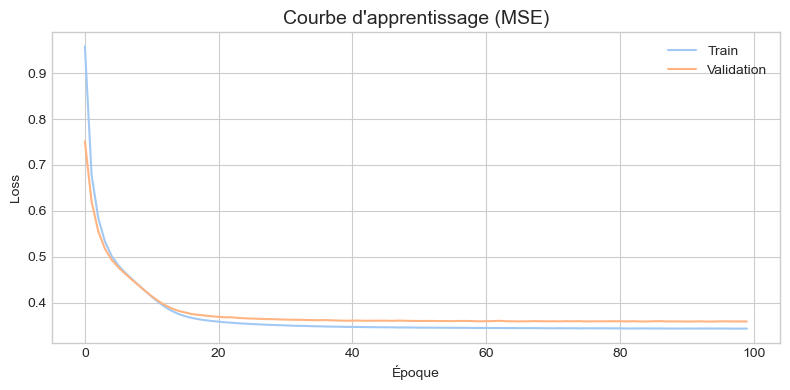

In [5]:
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Courbe d'apprentissage (MSE)", fontsize=14)
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 📈 Bloc 3 – Évaluation du Modèle sur l’Ensemble Complet

Nous appliquons l’autoencodeur à tous les fichiers (normaux + anomalies) et analysons :

- L’erreur de reconstruction (MSE)
- La distribution des erreurs selon les classes
- Le score AUC pour évaluer la séparation normal/anomaly


In [6]:
# ⚠️ Normalisation de tous les fichiers (X_mean déjà extrait en amont)
X_scaled_all = scaler.transform(X_mean)

# 🔄 Reconstruction avec l'autoencodeur
X_recon = autoencoder.predict(X_scaled_all)

# 🔥 Calcul de l’erreur de reconstruction par fichier
reconstruction_error = np.mean((X_scaled_all - X_recon) ** 2, axis=1)


969/969 [==============================] - 1s 1ms/step


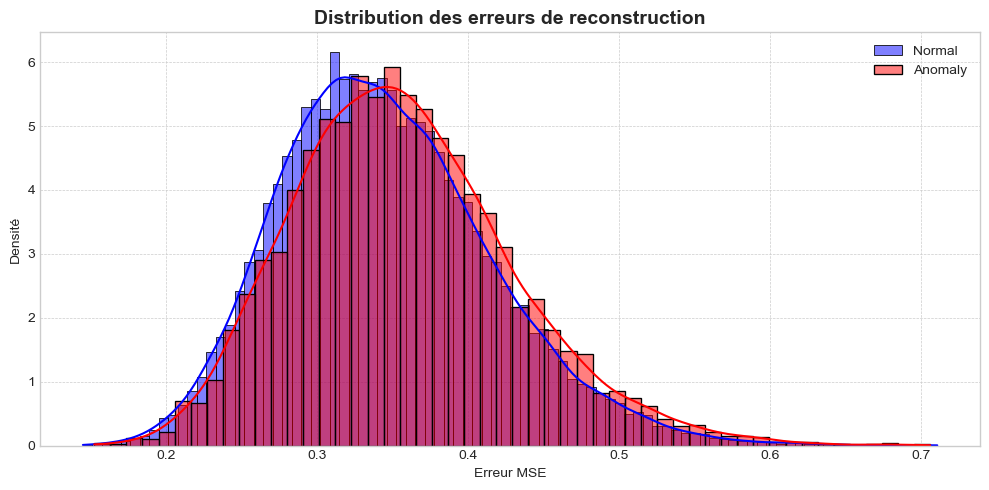

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(reconstruction_error[y == 0], label="Normal", color="blue", kde=True, stat="density")
sns.histplot(reconstruction_error[y == 1], label="Anomaly", color="red", kde=True, stat="density")
plt.title("Distribution des erreurs de reconstruction", fontsize=14, fontweight='bold')
plt.xlabel("Erreur MSE")
plt.ylabel("Densité")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [8]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y, reconstruction_error)
logger.info(f"📊 AUC basé sur l’erreur de reconstruction : {auc:.4f}")


2025-03-22 21:30:15 - INFO - 📊 AUC basé sur l’erreur de reconstruction : 0.5446


In [9]:
# Seuil basé sur le 95e percentile des erreurs des sons normaux
threshold = np.percentile(reconstruction_error[y == 0], 95)
logger.info(f"📌 Seuil automatique (95e percentile) = {threshold:.6f}")

# Prédiction binaire
y_pred = (reconstruction_error > threshold).astype(int)

# Matrice de confusion
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred, target_names=["Normal", "Anomaly"]))


2025-03-22 21:30:15 - INFO - 📌 Seuil automatique (95e percentile) = 0.471655


[[24242  1276]
 [ 5093   376]]
              precision    recall  f1-score   support

      Normal       0.83      0.95      0.88     25518
     Anomaly       0.23      0.07      0.11      5469

    accuracy                           0.79     30987
   macro avg       0.53      0.51      0.49     30987
weighted avg       0.72      0.79      0.75     30987



## 💾 Bloc 4 – Sauvegarde du Modèle et Export des Prédictions

À la fin de l'entraînement, nous sauvegardons :
- Le modèle autoencodeur (`.h5`)
- Le scaler (`.pkl`) utilisé pour la normalisation

Nous exportons aussi un fichier CSV contenant les prédictions de reconstruction :
- Score MSE
- Prédiction binaire (anomaly/normal)
- Label réel (si disponible)


In [10]:
from tensorflow.keras.models import save_model
import joblib

# 📂 Dossier de sauvegarde
model_dir = config.MODEL_DIR
model_dir.mkdir(parents=True, exist_ok=True)

# 🔐 Sauvegarde du modèle
model_path = model_dir / "autoencoder_model.h5"
save_model(autoencoder, model_path)

# 💾 Sauvegarde du scaler
scaler_path = model_dir / "scaler.pkl"
joblib.dump(scaler, scaler_path)

logger.info(f"✅ Modèle sauvegardé dans {model_path}")
logger.info(f"✅ Scaler sauvegardé dans {scaler_path}")


2025-03-22 21:30:15 - INFO - ✅ Modèle sauvegardé dans C:\Users\guidy\Documents\Datascience\Projet\Kaggle\DCASE2024_ASD_Project\data\models\autoencoder_model.h5
2025-03-22 21:30:15 - INFO - ✅ Scaler sauvegardé dans C:\Users\guidy\Documents\Datascience\Projet\Kaggle\DCASE2024_ASD_Project\data\models\scaler.pkl


In [11]:
# 🎯 Seuil défini (ex: 95e percentile sur les normaux)
threshold = np.percentile(reconstruction_error[y == 0], 95)
y_pred = (reconstruction_error > threshold).astype(int)

# 📁 Création DataFrame
df_pred = pd.DataFrame({
    "reconstruction_error": reconstruction_error,
    "true_label": y,
    "predicted_label": y_pred
})

# 🔢 Ajout des noms de fichiers si dispo (ex: metadata)
# df_pred["filename"] = metadata["filename"][:len(df_pred)]  # optionnel

# 💾 Export CSV
csv_path = model_dir / "reconstruction_predictions.csv"
df_pred.to_csv(csv_path, index=False)

logger.info(f"📄 Prédictions exportées vers {csv_path}")


2025-03-22 21:30:15 - INFO - 📄 Prédictions exportées vers C:\Users\guidy\Documents\Datascience\Projet\Kaggle\DCASE2024_ASD_Project\data\models\reconstruction_predictions.csv


## 💾 Bloc 5 – Sauvegarde du Seuil d'Anomalie (MSE)

Nous sauvegardons le seuil de classification basé sur l'erreur de reconstruction :

- Calculé sur les sons normaux (ex: 95e percentile)
- Sauvegardé dans un fichier `.npy` pour réutilisation dans le notebook d'inférence


In [12]:
# 🎯 Définition du seuil automatique (95e percentile des erreurs normales)
threshold = np.percentile(reconstruction_error[y == 0], 95)

# 💾 Sauvegarde du seuil dans un fichier .npy
np.save(config.THRESHOLD_PATH, threshold)

logger.info(f"📌 Seuil de détection sauvegardé : {threshold:.6f} → {config.THRESHOLD_PATH}")


2025-03-22 21:30:15 - INFO - 📌 Seuil de détection sauvegardé : 0.471655 → C:\Users\guidy\Documents\Datascience\Projet\Kaggle\DCASE2024_ASD_Project\data\models\threshold.npy


In [13]:
# 🔁 Chargement du seuil enregistré
threshold = np.load(config.THRESHOLD_PATH)
logger.info(f"✅ Seuil chargé pour l'inférence : {threshold:.6f}")


2025-03-22 21:30:15 - INFO - ✅ Seuil chargé pour l'inférence : 0.471655
